# 2) Entanglement entropy for the one-dimensional Heisenberg model


Consider the one-dimensional Heisenberg model with open boundary conditions:
\begin{equation}
    H = -\sum\limits_{i=1}^{N-1}J_i \vec S_i \cdot \vec S_{i+1}.
\end{equation}
For an even number of sites $N$ and $J_i<0$ (anti-ferromagnetic case), the ground state is non-degenerate.

Now divide the system in two parts $A$ and $B$ with sites $1,\dots, M_A$ and $M_A+1,\dots,N$.


**Entanglement entropy**

For a state
\begin{equation}
    |\psi\rangle = \sum\limits_{i=1}^{\dim_A} \sum\limits_{j=1}^{\dim_B} c_{ij} |{i}\rangle_A |{j}\rangle_B
\end{equation}

the reduced density operator is (with density operator $\hat\rho = |{\psi}\rangle\langle{\psi}|$)
\begin{align}
    \hat\rho_A 
        &= \operatorname{Tr}_B(\underbrace{|{\psi}\rangle\langle{\psi}|}_{=\hat\rho})
        \\
        &= \sum\limits_l \sum\limits_{i,i'} c_{i'l}c_{il}^* |{i'}\rangle_{AA}\langle{i}| 
        \\
        \leadsto \rho_A &= C C^\dagger
\end{align}
where $C$ is the matrix $(c_{ij})_{i=1,\dots,\dim_A; j=1,\dots,\dim_B}$, because $(\rho_A)_{nm} = \sum\limits_l \underbrace{(C)_{nl}}_{=c_{nl}} \underbrace{(C^\dagger)_{lm}}_{=c_{ml}^*}$.

Then the entanglement entropy is
\begin{align}
    S_e 
        &= - \operatorname{Tr}_A [\hat\rho_A \cdot \ln\hat\rho_A] \\
        &= - \sum\limits_\alpha w_\alpha \cdot \ln w_\alpha
\end{align}
with eigenvalues $w_\alpha$ of $\rho_A$.

<blockquote>
Analogous for $\rho_B$ it is:
\begin{align}
    \hat\rho_B 
        &= \operatorname{Tr}_A(\underbrace{|{\psi}\rangle\langle{\psi}|}_{=\hat\rho})
        \\
        &= \sum\limits_l \sum\limits_{j,j'} c_{lj'}c_{lj}^* |{j'}\rangle_{BB}\langle{j}| 
        \\
        (\rho_A)_{nm} &= \sum\limits_l \underbrace{(C)_{ln}}_{=c_{ln}} \underbrace{(C^\dagger)_{ml}}_{=c_{lm}^*}
        \\
        &= \sum\limits_l (C^\dagger)_{ml}(C)_{ln}
        \\
        \leadsto \rho_A &= C^\dagger C
\end{align}
</blockquote>

To numerically figure out $\rho_A$ to calculater $S_e$, we need to find $C$ from a given $|\psi\rangle$.

<blockquote>
The direct method over the definition: Calculate the partial trace of $|\psi\rangle\langle\psi|$ to get $\rho_A$ and then proceed (complicated and includes all steps of the better option below).
</blockquote>

**Calculate $C$ directly from $|\psi\rangle$:** <br/>
Consider $|\psi\rangle$ is given in the computational basis of the joint system as a vector of coefficients $\psi:=\vec\psi$ with
\begin{align}
    |\psi\rangle 
        = \sum\limits_{i=0}^{2^N-1} \psi_i |i\rangle_N
        = \sum\limits_{i=0}^{2^N-1} \psi_i |i_1,i_2,\dots,i_N\rangle
\end{align}

If we now divide the system of $N$ sites in $M_A$ and $M_B = N-M_A$ sites, this can be seen as writing $|i_1,i_2,\dots,i_N\rangle$ as a product state $|i_1,i_2,\dots,i_{M_A}\rangle\otimes |i_{M_A+1},\dots,i_N\rangle$

\begin{align}
    |\psi\rangle 
        &= \sum\limits_{i=0}^{2^N-1} \psi_i \underbrace{|i_1,\dots,i_{M_A}\rangle}_{=:|j\rangle} \otimes \underbrace{|i_{M_A+1},\dots,i_N\rangle}_{=:|l\rangle}
        \\
        &= \sum\limits_{j=0}^{2^{M_A}-1}\sum\limits_{l=0}^{2^{M_B}-1} (C)_{jl} |j\rangle \otimes |l\rangle
\end{align}
with now constructed $C$:
\begin{equation}
    (C)_{jl} = \psi_{dec([j\otimes l]_2)} = \psi_{dec([j_1,\dots,j_{M_A},l_1,\dots,l_{M_B}]_2)} = \psi_{i(j,l)},
\end{equation}
where $dec(x)$ is the decimal representation of binary $x$.


In [17]:
#using Combinatorics
#using ProgressMeter
using Distributed
using SharedArrays
using Plots

In [2]:
addprocs(10)
#rmprocs(workers())

10-element Vector{Int64}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11

In [3]:
@everywhere using LinearAlgebra

In [4]:
@everywhere begin
    # some helper functions
    n_dual(n, pad=0) = digits(n, base=2, pad=pad)
    dec2bin(x, pad=0) = join(digits(x, base=2, pad=pad))
    bin2dec(x) = parse(Int, join(reverse(string.(x))), base=2)
end

In [5]:
# Test N=3
ψ = [1 0 1 0 0 0 0 0] # =̂ |000⟩ + |010⟩ = |0⟩⊗(|00⟩ + |10⟩)

1×8 Matrix{Int64}:
 1  0  1  0  0  0  0  0

In [6]:
# Test
M_A = 1 # dim_A = 2^M_A
M_B = 2 # dim_B = 2^M_B

# convert ψ to C:
@everywhere function ψ2C(ψ, M_A, M_B)
    C = zeros(2^M_A,2^M_B)
    for j in 0:(2^M_A-1)
        for l in 0:(2^M_B-1)
            C[j+1,l+1] = ψ[bin2dec(dec2bin(j,M_A) * dec2bin(l, M_B)) + 1]
            #println("$j, $l: ", dec2bin(j,M_A),",", dec2bin(l, M_B), " → ", C[j+1,l+1])
        end
    end
    return C
end

In [7]:
# Test
C = ψ2C(ψ, M_A, M_B)

2×4 Matrix{Float64}:
 1.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0

In [8]:
@everywhere function wₐlnwₐ(wₐ)
    if wₐ <= eps() 
        return 0.0 # lim(x→0) x ln(x) = 0
    end
    return wₐ * log(wₐ)
end

In [9]:
@everywhere function Sₑ(ρ)
    return -sum(wₐlnwₐ.(eigvals(ρ)))
end

In [10]:
# Test
ρ = 1/2 * C * C' # normalization here for precision

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  0.0

In [11]:
# Test
println(eigvals(ρ))
println(Sₑ(ρ))

[0.0, 1.0]
-0.0


## a) 1d-Heisenberg model for $N=10$ and $J=-1$

In [12]:
#using SymPy

In [13]:
@everywhere include("hamilton_spins.jl");

Calculate the ground state of the 1d-Heisenberg model:

In [14]:
J = -1
N = 10

Js = reset_Js(N)

# couplings between (i,i+1) for α=x (1)
for i in 1:(N-1)
    Js[1][i,i+1] = J
end

Js[2] = Js[1]
Js[3] = Js[1]

H = calculate_hamilton_matrix(Js, N)
ψ_g = eigvecs(rationalize.(Matrix(H)))[:,1];

In [15]:
E_g = eigvals(rationalize.(Matrix(H)))[1]

-4.258035207282881

In [16]:
Sₑs = zeros(N-1)

for M_A in 1:(N-1)
    M_B = N-M_A
    # calculate C
    C = ψ2C(ψ_g, M_A, M_B)
    Sₑs[M_A] = Sₑ(C * C')
    println("$M_A: ", Sₑs[M_A])
end

Sₑs

1: 0.6931471805599454
2: 0.4078929253951651
3: 0.7261925797876849
4: 0.4923347211598358
5: 0.7378694353603878
6: 0.49233472115983545
7: 0.7261925797876837
8: 0.4078929253951949
9: 0.6931471805599454


9-element Vector{Float64}:
 0.6931471805599454
 0.4078929253951651
 0.7261925797876849
 0.4923347211598358
 0.7378694353603878
 0.49233472115983545
 0.7261925797876837
 0.4078929253951949
 0.6931471805599454

## b)

In [18]:
function Sₑmax(M_A, M_B)
    return log(minimum([2^M_A, 2^M_B]))
end

Sₑmax (generic function with 1 method)

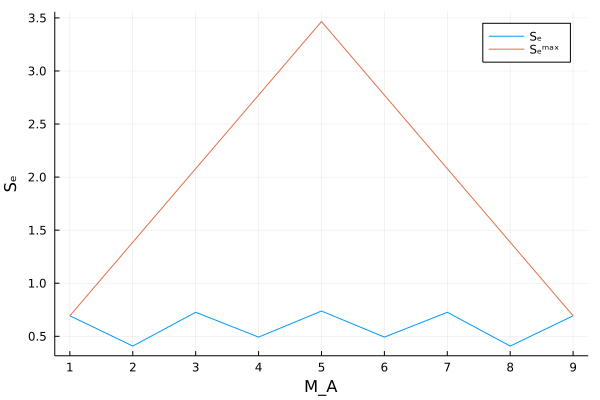

In [19]:
plot(Sₑs, label="Sₑ")
plot!(1:(N-1), Sₑmax.(1:(N-1), N .- collect(1:(N-1))), label="Sₑᵐᵃˣ")
xlabel!("M_A")
ylabel!("Sₑ")
xticks!(1:N-1)

## c)

### verifying the $J=-1$ case

In [22]:
N6 = 6


Ji = -1 * ones(N6-1)

Js_N6 = reset_Js(N6)

# couplings between (i,i+1) for α=x (1)
for i in 1:(N6-1)
    Js_N6[1][i,i+1] = Ji[i]
end

Js_N6[2] = Js_N6[1]
Js_N6[3] = Js_N6[1]

H_N6 = calculate_hamilton_matrix(Js_N6, N6)
ψ_N6_g = eigvecs(rationalize.(Matrix(H_N6)))[:,1];

In [23]:
C_N6 = ψ2C(ψ_N6_g, 3,3)

Sₑ(C_N6' * C_N6)

0.7113730475806012

1: 0.6931471805599454
2: 0.4078929253951651
3: 0.7261925797876849
4: 0.4923347211598358
5: 0.7378694353603878


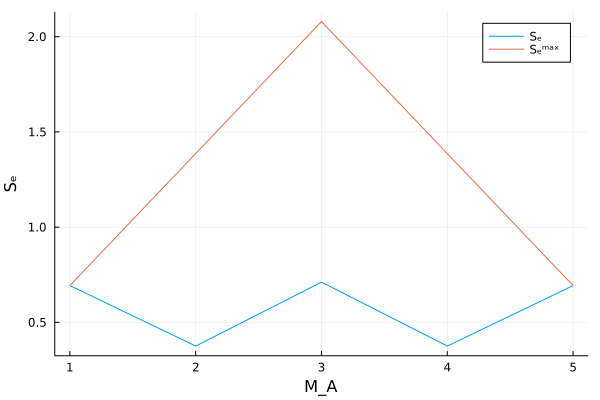

In [24]:
Sₑs_N6 = zeros(N6-1)

for M_A in 1:(N6-1)
    M_B = N6-M_A
    # calculate C
    C = ψ2C(ψ_N6_g, M_A, M_B)
    Sₑs_N6[M_A] = Sₑ(C * C')
    println("$M_A: ", Sₑs[M_A])
end

Sₑs_N6

plot(Sₑs_N6, label="Sₑ")
plot!(1:(N6-1), Sₑmax.(1:(N6-1), N6 .- collect(1:(N6-1))), label="Sₑᵐᵃˣ")
xlabel!("M_A")
ylabel!("Sₑ")
xticks!(1:N6-1)

$\checkmark$

### Now find $-1 \leq J_i < 0$ s.t. $S_e >1.5$

In [74]:
@everywhere Jis = collect(Iterators.product([-1:.05:0 for i in 1:5]...));
length(Jis)

4084101

In [75]:
@everywhere N6 = 6
@everywhere N=N6


#Ji = -1 * ones(N6-1)
#Ji = [0, -.1, -1, -0.1, 0, 0]
matches = SharedArray{Bool}(length(Jis))
@sync @time begin 
@distributed for j in 1:length(Jis)
    Ji = Jis[j]

    Js_N6 = reset_Js(N6)

    # couplings between (i,i+1) for α=x (1)
    for i in 1:(N6-1)
        Js_N6[1][i,i+1] = Ji[i]
    end

    Js_N6[2] = Js_N6[1]
    Js_N6[3] = Js_N6[1]

    H_N6 = calculate_hamilton_matrix(Js_N6, N6)
    ψ_N6_g = eigvecs(rationalize.(Matrix(H_N6)))[:,1]

    C_N6 = ψ2C(ψ_N6_g, 3,3)

    S = Sₑ(C_N6' * C_N6)
    if S > 1.5
        #println("$j: ", S)
        matches[j] = true
    end
end
end
#println("done. ", matches)
#println("done. ", matches, "\n")
println(sum(matches), " matches")

  0.015912 seconds (7.92 k allocations: 522.758 KiB, 97.01% compilation time)
0 matches
